# Replication: Shu *et al*, 2020
## Introduction

This notebook attempts to replicate the following paper with the [PPMI](http://ppmi-info.org) dataset:

<div class="alert alert-block alert-success">
Shu, Zhen‐Yu, et al. <a href="https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.28522?casa_token=Ab53WvMlODcAAAAA%3AXcgDLmq8egqW7uwd2g3jY9jIljhLu3VhIbvMWgbcfoWOxjO_9H7Arf91t2FBZDZ8E94Je4Wmrn0ZmkeZ">Predicting the progression of Parkinson's disease using conventional MRI and machine learning: An application of radiomic biomarkers in whole‐brain white matter.</a> Magnetic Resonance in Medicine 85.3 (2021): 1611-1624.</div>

This study recruited 72 patients with progressive PD and 72 patients with stable PD matched by age, sex and category of HYS. The objective of the study is to develop and validate a radiomics model to predict the progression of Parkinson disease. This following population from PPMI was used:

<img src="./images/table.png" width="80%"/>

The main results show that the the areas under curve of the radiomics model reaches 0.795 which suggests that the use of a simple radiomics signature built from whole-brain white matter can be a useful tool for the assessment and monitoring of PD progression

<img src="./images/result.png" width="30%"/>

The remainder of this notebook is an attempt to replicate this result using the PPMI dataset.

## Initial setup

Let's initialize the notebook dependencies:

In [1]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils('shu-etal')
utils.notebook_init()
# random_seed = 1 # to be tested
random_seed = 2  # no significant cluster
# random_seed = 3 # no significant cluster
# random_seed = 4 # no significant cluster

removing link inputs
removing link outputs
Installing notebook dependencies (see log in install.log)... 
This notebook was run on 2022-10-05 18:36:50 UTC +0000


## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as much as possible. As in other LivingPark replications, we will use the same sample size as the original study. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort: 
* Age at visit (this could also be retrieved from imaging data)
* Demographics (to retrieve sex)
* Participant Status (to retrieve PD patients)

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, you will need to enter your PPMI username and password. In case you don't have a PPMI account, you can request one [here](http://ppmi-info.org).

In [2]:
required_files = [
    'Age_at_visit.csv', 
    'Demographics.csv', 
    'Participant_Status.csv'
]

utils.download_ppmi_metadata(required_files)

Download skipped: No missing files!


### Additional data

We will also need `MRI_info.csv` and `MDS_UPDRS_Part_III_clean.csv` that are produced by another LivingPark notebook available at https://github.com/LivingPark-MRI/ppmi-MRI-metadata and https://github.com/LivingPark-MRI/ppmi-treatment-and-on-off-status respectively. 

The `MRI_info.csv` file contains a list usable T1-weighted MRIs. This is important since the original study uses  T1-weighted MRIs from PPMI. Therefore, we need to filter out all other scanners. The `MDS_UPDRS_Part_III_clean.csv` file is a refined version of PPMI's UPDRS III data.

File downloaded
['COR', 'Coronal', 'Cal Head 24', 'Transverse', 'tra_T1_MPRAGE', 'TRA']
['AX', 'axial', 'Phantom']
{'Screening': 'SC', 'Baseline': 'BL', 'Month 12': 'V04', 'Month 24': 'V06', 'Month 36': 'V08', 'Month 48': 'V10', 'Symptomatic Therapy': 'ST', 'Unscheduled Visit 01': 'U01', 'Unscheduled Visit 02': 'U02', 'Premature Withdrawal': 'PW'}
Saved in MRI_info.csv
This notebook was run on 2022-10-05 18:36:50 UTC +0000
File downloaded


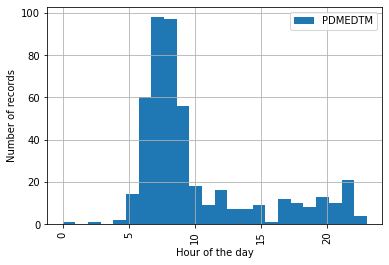

Removed 40 records where PDSTATE=ON and EXAMTM<PDMEDTM
Number of removed records: 5
Found 0 records in Case 3.a
Removed 1 record(s) with missing EXAMTM or PDMEDTM
Cleaned file saved in MDS_UPDRS_Part_III_clean.csv
True


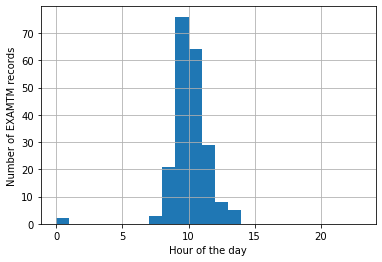

In [3]:
# Import notebooks and execute

from livingpark_utils.scripts import (
    mri_metadata,
    pd_status
)

## Hoehn & Yahr stage

The first dataframe required will be extracted from `MDS_UPDRS_Part_III_clean.csv` with the objective to select a group of patients that are off medication during examination.

In [4]:
import os
import pandas as pd

# Define data directory for additional data
data_dir = "data"

# Load PPMI UPDRS III data (modified)
df_hy = pd.read_csv(
    os.path.join(data_dir, 'MDS_UPDRS_Part_III_clean.csv')
)

# Drop unnecessary columns
keep_cols = ['EVENT_ID', 'PATNO', 'NHY', 'PDSTATE', 'PDTRTMNT']
df_hy = df_hy.drop([x for x in df_hy.columns if x not in keep_cols], axis=1)

# Display number of patients
df_hy.groupby('PDSTATE').count()

,PATNO,EVENT_ID,NHY,PDTRTMNT
PDSTATE,,,,
OFF,12979,12979,12972,12979
ON,5666,5666,5663,5666


## Demographics

Needed for sex. (0: Female, 1: Male)

In [5]:
# Load PPMI Demographics data
demo = pd.read_csv(
    os.path.join(utils.study_files_dir, 'Demographics.csv')
)

# Drop useless columns
keep = ['PATNO', 'SEX']
demo = demo.drop([x for x in demo.columns if x not in keep], axis=1)

# Convert data to 0/1 values
demo['SEX'] = demo['SEX'].astype(int)

# Show sex stats (0: Female, 1: Male)
demo.groupby('SEX').count()

,PATNO
SEX,
0,993
1,1350


There is a decent balance between the number of males and females.

## Age at visit

Needed for age.

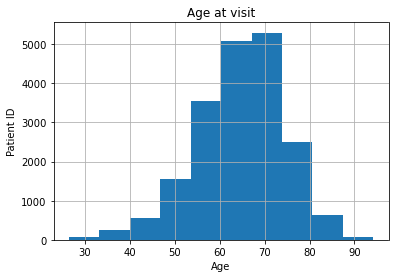

In [6]:
import matplotlib.pyplot as plt

# Load PPMI age data
df_age = pd.read_csv(
    os.path.join(utils.study_files_dir, 'Age_at_visit.csv')
)

# Show histogram
df_age['AGE_AT_VISIT'].hist()

# Histogram settings
plt.title('Age at visit')
plt.xlabel('Age')
plt.ylabel('Patient ID');

Our histogram suggests that the majority of patients are between the ages of 60 and 72.

## MRI availability

The study performed contains patients evaluted over the course of 3 years and classifies the patients into progression and stable groups. The `MRI_info.csv` has information on every patient and every single visit. We filter out patients that do not have 3 year of visit history.

In [7]:
import numpy as np

# Load MRI info data
mri_df = pd.read_csv(
    os.path.join(data_dir, 'MRI_info.csv')
)

# Keep rows with visits we need
# We need a 3-year gap between visits so the only possible pairs are the following ones:
visits = {'BL': 'V08', 
          'V04': 'V10',
          'V06': 'V12',
          'V08': 'V13',
          'V10': 'V14'}

mri_df.rename(columns={'Subject ID': 'PATNO', 'Visit code': 'EVENT_ID'}, inplace=True)
mri_df = mri_df[mri_df['EVENT_ID'].isin(visits)]
mri_df["PATNO"] = mri_df["PATNO"].astype(np.int64)
mri_df["Description"] = mri_df["Description"].astype(str)

# Show pairs formed
mri_df.groupby('EVENT_ID').count()

,PATNO,Sex,Visit,Age,Description
EVENT_ID,,,,,
BL,1153,1153,1153,1153,1153
V04,274,274,274,274,274
V06,324,324,324,324,324
V08,2,2,2,2,2
V10,357,357,357,357,357


## Participant status

Since this study is revolved around patients with Parkinson's disease, this will help filter out all other patients.

In [8]:
# Read CSV | 1: PD, 2: Cohort
participant_df = pd.read_csv(
    os.path.join(utils.study_files_dir, 'Participant_Status.csv')
)

# Keep useful columns
participant_df = participant_df[["PATNO", "COHORT_DEFINITION"]]
participant_df = participant_df[participant_df["COHORT_DEFINITION"]=="Parkinson's Disease"]

# Display stats
participant_df.groupby('COHORT_DEFINITION').count()

,PATNO
COHORT_DEFINITION,
Parkinson's Disease,1153


## Merge all dataframes together

Before performing cohort matching, we need to build one final dataframe that consists of all the data we just extracted.

In [9]:
# keys = ['PATNO', 'EVENT_ID']

df_mri_age = df_age.merge(mri_df, how='right')
df_mri_age['AGE_AT_VISIT'].fillna(df_mri_age['Age'])
df_mri_age = df_mri_age.merge(participant_df, on="PATNO")

df = df_hy.merge(df_mri_age, how='inner')

# Display patients per HY stage
df.groupby('NHY').count()

,PATNO,EVENT_ID,PDSTATE,PDTRTMNT,AGE_AT_VISIT,Sex,Visit,Age,Description,COHORT_DEFINITION
NHY,,,,,,,,,,
0,4,4,4,4,4,4,4,4,4,4
1,363,363,363,363,363,363,363,363,363,363
2,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051
3,64,64,64,64,64,64,64,64,64,64
4,10,10,10,10,10,10,10,10,10,10
UR,1,1,1,1,1,1,1,1,1,1


## Format data by visit pairs

Finally, we form the data such that each row contains a patients' data from both visits.

In [10]:
def next_visit(x):
    '''
    Returns the next visit (3y) after baseline visit.
    '''
    
    return visits[x]

def save_exclusions(exclude):
    '''
    Saves the patients to exclude in case errors occur.
    
    exclude: list
        List of subject IDs to exclude
    '''
    
    with open('exclusions.csv', 'w') as f:
        for index, subId in enumerate(exclude):
            f.write(str(subId))
            if index!=len(exclude)-1:
                f.write('\n')
        
def open_exclusions() -> set:
    '''
    Opens the list of exclusions in a set.
    '''
    
    exclude = set()
    if os.path.exists('exclusions.csv'):
        with open('exclusions.csv', 'r') as f:
            for subId in f:
                exclude.add(int(subId))
    return exclude

In [11]:
def build_visit_df():
    visits_df = df
    
    # Exclude patients (if applicable)
    exclude_patients = open_exclusions()
    if len(exclude_patients) > 0:
        for patient in exclude_patients:
            visits_df = visits_df[visits_df["PATNO"]!=patient]

    # Set id of second visit in pair
    visits_df['next_visit'] = visits_df['EVENT_ID'].apply(next_visit)

    # Retrieve H&Y score of next visit
    visits_df = visits_df.merge(df_hy, how='left', left_on=['PATNO', 'next_visit'], right_on=['PATNO', 'EVENT_ID'])

    # Add patient sex to visit pairs
    visits_df = visits_df.merge(demo, on=['PATNO'])

    # Define visit as stable if NHY (first visit)
    visits_df['stable'] = (visits_df['NHY_x'] == visits_df['NHY_y'])

    # Keep visit pairs with same PDSTATUS
    visits_df = visits_df[visits_df["PDSTATE_x"]==visits_df["PDSTATE_y"]]

    # Display data pairs
    visits_df.groupby(['stable', 'NHY_x'], dropna=False).count()
    
    return visits_df

visits_df = build_visit_df()
visits_df.groupby(['stable', 'NHY_x'], dropna=False).count()

PATNO  EVENT_ID_x  PDSTATE_x  PDTRTMNT_x  AGE_AT_VISIT  Sex  \
stable NHY_x                                                                
False  0          3           3          3           3             3    3   
       1        165         165        165         165           165  165   
       2        113         113        113         113           113  113   
       3         12          12         12          12            12   12   
       4          2           2          2           2             2    2   
True   1         71          71         71          71            71   71   
       2        487         487        487         487           487  487   
       3          1           1          1           1             1    1   

              Visit  Age  Description  COHORT_DEFINITION  next_visit  \
stable NHY_x                                                           
False  0          3    3            3                  3           3   
       1        165  165          165                165         165   
       2        113  113          113                113         113   
       3         12   12           12                 12          12   
       4          2    2            2                  2           2   
True   1         71   71           71                 71          71   
       2        487  487          487                487         487   
       3          1    1            1                  1           1   

              EVENT_ID_y  PDSTATE_y  NHY_y  PDTRTMNT_y  SEX  
stable NHY_x                                                 
False  0               3          3      3           3    3  
       1             165        165    165         165  165  
       2             113        113    113         113  113  
       3              12         12     12          12   12  
       4               2          2      2           2    2  
True   1              71         71     71          71   71  
       2             487        487    487         487  487  
       3               1          1      1           1    1

# Matching

We implemented a nearest-neighbor matching loop based on the Euclidean distance. We will match stable and progressive groups for age and sex for each H&Y value.

## Normalization

We need to normalize age or else it will dominate sex in the Euclidean distance.

In [12]:
df = visits_df
to_normalize = ['AGE_AT_VISIT'] 
for var in to_normalize:
    df[f'{var}_norm'] = (df[var] - df[var].mean())/df[var].std()
df.describe()

,PATNO,PDTRTMNT_x,AGE_AT_VISIT,Age,PDTRTMNT_y,SEX,AGE_AT_VISIT_norm
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,8.540000e+02
mean,15214.951991,0.745902,62.879859,62.892974,0.967213,0.640515,-9.497997e-16
std,20819.838996,0.435608,9.322289,9.319213,0.178183,0.480131,1.000000e+00
min,3002.000000,0.000000,34.800000,34.800000,0.000000,0.000000,-3.012121e+00
25%,3359.000000,0.000000,55.725000,55.850000,1.000000,0.000000,-7.675003e-01
50%,3811.000000,1.000000,64.000000,64.100000,1.000000,1.000000,1.201572e-01
75%,40338.000000,1.000000,70.100000,70.100000,1.000000,1.000000,7.745029e-01
max,75562.000000,1.000000,83.300000,83.400000,1.000000,1.000000,2.190464e+00


## Matching loop

Nearest neighbor matching loop applied for each H&Y value to extract stable and progressive populations with matched sex and age.

In [13]:
def nn(x, df, matched_vars):
    '''
    Find index of nearest neighbor of x in df
    '''
    
    # Select only the subjects with the same H&Y score
    df_hy_match = df[df['NHY_x'] == x['NHY_x'].values[0]]
 
    # Compute squared distance between x and all elements in df, using normalized variables
    df_hy_match['dist'] = sum((df_hy_match[f'{var}']-x[f'{var}'].values[0])**2 for var in matched_vars)
    
    # Return the element in df with the smallest distance
    df_hy_match.sort_values('dist', inplace=True)
    return df_hy_match.head(1)  ## there's probably a better way to do it but it should work

def match(n, group1_df, group2_df, matched_vars):
    '''
    Randomly pick n elements in group1_df, then find n matching elements in group2_df.
    Ensure that each group only contains 1 or less element from each patient and that 
    no patient has elements in both groups.
    '''
    
    from numpy.random import choice, seed

    # Select n random patients in group1
    group1_patnos = sorted(pd.unique(group1_df['PATNO']))
    seed(0)  # change this to bootstrap population
    group1_patnos_sample = choice(group1_patnos, n, replace=False)
    
    # Remove the selected patients from group2
    for p in group1_patnos_sample:
        group2_df = group2_df[group2_df['PATNO']!=p]
    
    group1_matched = pd.DataFrame(columns=group1_df.columns)
    group2_matched = pd.DataFrame(columns=group1_df.columns)

    for p in group1_patnos_sample:  # for each patient in sampled list
        # Pick a random element from this patient in group1
        s = group1_df[group1_df['PATNO'] == p].sample(1)
        # Find the best match in group2
        t = nn(s, group2_df, matched_vars)
        # Add s and t to matched groups
        group1_matched = group1_matched.append(s)
        group2_matched = group2_matched.append(t)
        # Remove t's patient from group 2 so that it doesn't get selected again
        group2_df = group2_df[group2_df['PATNO']!=t['PATNO'].values[0]]
    
    return group1_matched, group2_matched

In [14]:
matched_vars = ['AGE_AT_VISIT_norm', 'SEX']

        
# Apply matching to get 40patients with H&Y=1
stable1, progr1 = match(40,
                        df[(df['stable'] == True) & (df['NHY_x'] == "1")],
                        df[(df['stable'] == False) & (df['NHY_x'] == "1")],
                        matched_vars)
patids = pd.unique(pd.concat([stable1, progr1], axis=0)["PATNO"])
df_filtered = df[~df['PATNO'].isin(patids)]

# Apply matching to get 32patients with H&Y=2
stable2, progr2 = match(32,
                        df_filtered[(df_filtered['stable'] == True) & (df_filtered['NHY_x'] == "2")],
                        df_filtered[(df_filtered['stable'] == False) & (df_filtered['NHY_x'] == "2")],
                        matched_vars)

stable = stable1.append(stable2)
progr = progr1.append(progr2)

## Sanity checks

In order to ensure that the cohort built meets the requirements, we ensure that:

1. Both groups have equal size

2. No patient is present more than once in each group

3. Patients in group A aren't in group B and vice versa

In [15]:
for (a, b) in [(stable1, progr1), (stable2, progr2)]:
    # Both groups have equal size
    assert(len(a) == len(b))
    # No patient is present more than once in each group
    for x in [a, b]:
        patnos_x = pd.unique(x['PATNO'])
        assert(len(patnos_x)==len(x)), x
    # Patients in a aren't in b
    patnos_a = pd.unique(a['PATNO'])
    patnos_b = pd.unique(b['PATNO'])
    for p in patnos_a:
        assert(p not in patnos_b), f'PATNO {p} appears in a and b'
        
# Patients in each cohort do not replicate
assert len(set(pd.unique(progr["PATNO"])) & (set(pd.unique(stable["PATNO"]))))==0, "Patients occur in both groups"

print('All good!')

All good!


## Cohort summary

In [16]:
cohort_stats = pd.DataFrame(columns=[f"Stable", f"Progression"])

cohort_stats.loc["Subjects, No."] = [len(stable), len(progr)]

cohort_stats.loc["F/M, No."] = [
    f"{len(stable[stable['SEX']==0])}/{len(stable[stable['SEX']==1])}",
    f"{len(progr[progr['SEX']==0])}/{len(progr[progr['SEX']==1])}",
]

cohort_stats.loc["Age, mean +/- SD"] = [
    f"{round(stable['Age'].mean(),1)} +/- {round(stable['Age'].std(),1)}",
    f"{round(progr['Age'].mean(),1)} +/- {round(progr['Age'].std(),1)}",
]

cohort_stats.loc["Hoehn & Yahr Stage 1 (n)"] = [
    f"{len(stable[stable['NHY_x']=='1'])}",
    f"{len(progr[progr['NHY_x']=='1'])}"
]

cohort_stats.loc["Hoehn & Yahr Stage 2 (n)"] = [
    f"{len(stable[stable['NHY_x']=='2'])}",
    f"{len(progr[progr['NHY_x']=='2'])}"
]

cohort_stats

,Stable,Progression
"Subjects, No.",72,72
"F/M, No.",34/38,32/40
"Age, mean +/- SD",59.8 +/- 9.2,61.4 +/- 9.1
Hoehn & Yahr Stage 1 (n),40,40
Hoehn & Yahr Stage 2 (n),32,32


The demographics of the replicated cohort are close enough to the original study. The goal was to match patients based on sex, age and initial H&Y stage. In the original study, the cohort built consists of 47 patients in stage 1 and 25 patients in stage 2. This could not be achieved since the UPDRS_III data file used in this replication was modified to only contain patients off medication during examination.

## Pre-processing

Pre-processing consists of:

   1. Extraction of white matter volumes using SPM12
   2. Extraction of radiomics features
   
Before starting, we need to build a DataFrame that contains every patient with the necessary information.

In [17]:
# Create a joint dataframe
cohort = pd.concat([stable, progr])

# Keep columns required
cohort = cohort[["PATNO", "EVENT_ID_x", "Description"]].rename(columns={"EVENT_ID_x": "EVENT_ID"})

### Extraction of white matter volumes using SPM12

#### Imaging data download
Execute PPMI downloader to download `NIfTi` MRI's of every patient.

In [18]:
utils.download_missing_nifti_files(cohort, link_in_outputs=True)

Number of available subjects: 144
Number of missing subjects: 0


#### White matter extraction
Execute SPM12 using a Docker image to compute segmented masks.

In [19]:
utils.spm_compute_missing_segmentations(cohort)

Missing segmentations: 0


## Quality control
Before extracting radiomic features, we would like to ensure the white matter segmentations went correctly.

Folder qc_1112445622883052127 already exists, skipping image export  (remove folder or use --force to force).
Wrote qc_1112445622883052127/animation.gif


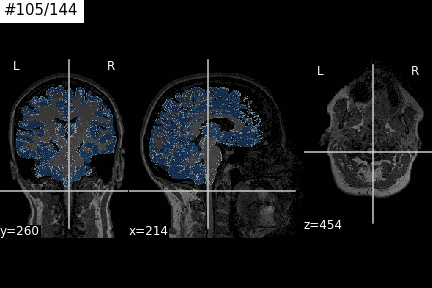

In [20]:
utils.qc_spm_segmentations(cohort, mni_space=False, show_wm=True, show_gm=False, cut_coords=None)

#### Image Validity Protocol (TODO: Build protocol for QC)

In order that the brain mask was well computed, we need to ensure that:

    1 - The white matter masks is well aligned 
    2 - ...

### Extraction of radiomics features

SPM12 generates multiple tissue probability maps. Our interest is the `c2` mask which is the segmented white matter. Using NiBabel, we will convert all the maps to NumPy arrays and construct binary masks for white matter. From there, we will compute the radiomics feaatures using PyRadiomics.

In [21]:
import glob, json, csv, logging
from radiomics import featureextractor
import nibabel as nib
from IPython.display import display, Markdown
from tqdm.notebook import tqdm

def save_radiomics_to_json(data):
    '''
    Saves the radiomic features in a JSON file
    
    data: OrderedDict
        Output of radiomic features stored in an OrderedDict.
    '''
    
    def default(obj):
        if type(obj).__module__ == np.__name__:
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            else:
                return obj.item()
        raise TypeError('Unknown type:', type(obj))

    dumped = json.dumps(data, default=default)

    with open(os.path.join("outputs", "radiomics", "radiomicsOutput.json"), 'w') as f:
        json.dump(dumped, f)

def get_radiomics_json() -> dict:
    '''
    Return a dictionary containing the radiomics features original output.
    '''
    
    with open(os.path.join("outputs", "radiomics", "radiomicsOutput.json"), 'r') as f:
        return json.loads(json.load(f))
    
def compute_radiomics(cohort, force=False):
    '''
    Runs PyRadiomics to compute radiomic features.
    
    cohort: pd.DataFrame
        Cohort containing patients IDs and MRI file paths
        
    force: bool, optional
    '''
    
    # Instantiate the extractor
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.disableAllFeatures()
    extractor.enableFeatureClassByName("glcm")
    extractor.enableFeatureClassByName("glszm")
    extractor.enableFeatureClassByName("glrlm")
    
    # Ignore non-error logs
    logger = logging.getLogger("radiomics")
    logger.setLevel(logging.ERROR)
    
    # Initiate results dictionary
    radiomicsResults = {}
        
    # If a subject fails, add to "exclusion" array
    exclude = set() if not os.path.exists("exclusions.csv") else open_exclusions()
    
    # Create directory to save results
    folder = os.path.join("outputs", "radiomics")
    if not os.path.exists(folder):
        os.makedirs(os.path.join("outputs", "radiomics"), exist_ok=True)
        
    file_exists = os.path.exists(os.path.join("outputs", "radiomics", "radiomicsOutput.json"))
    
    if file_exists and not force:
        print("Skipping computation of radiomics, use force=True to run anyway.")
        
    else:
        
        # Loop through every subject
        for inputMask in tqdm(cohort["File name"]):
            masks = []
            affines = []
            subjectId = inputMask.split('/')[2]
            segmentationDirectory = os.path.join(
                *inputMask.replace("inputs", "outputs/pre_processing", 1).split("/")[1:-1]
            )

            # Get every mask per subject (c0 to c5)
            for segmentation in sorted(glob.glob(f"{segmentationDirectory}/c*PPMI*")):
                mask = nib.load(segmentation)
                affines.append(mask.affine)
                masks.append(mask.get_fdata())

            # Combine all masks in one array
            maskArray = np.array(masks)

            # Get all indices (0 to 5)
            indices = np.argmax(maskArray, axis=0)

            # Replace classes that are not WM to 0
            indices[indices!=1] = 0.0
            indices = indices.astype(np.float64)

            # Save as NifTi
            new_mask = nib.Nifti1Image(indices, affine=affines[1]) 
            mask_path = os.path.join(segmentationDirectory, "wm.nii")
            nib.save(new_mask, os.path.join(segmentationDirectory, "wm.nii"))

            # Compute radiomic features and save to dict
            try:
                radiomicsResults[subjectId] = extractor.execute(inputMask, mask_path)
            except:
                subId = int(subjectId.split("-")[1])
                if subId not in exclude:
                    exclude.add(subId)
                print(f"Error for subject, adding to exclusions list...")
                continue

            # Delete WM segmentation
            os.system(f"rm -rf {mask_path}")

            # Save exclusion file
            save_exclusions(exclude)

        # Save as JSON
        save_radiomics_to_json(radiomicsResults)
        
    # If radiomics errors occur, run back from cell reference
    if len(radiomicsResults) != len(cohort):
        return display(Markdown('[Due to radiomic computation errors, please run the notebook again from this cell (click me)](#Merge-all-dataframes-together)'))

**The PyRadiomics library may fail due to errors found in the MRI scan. If that is the case, the code will prompt you to run back the notebook from this [cell](#Merge-all-dataframes-together). Additionally, if the radiomic features already exist, you may need to use `force=True` to run the following cell again.**

In [22]:
compute_radiomics(cohort, force=False)

Skipping computation of radiomics, use force=True to run anyway.


[Due to radiomic computation errors, please run the notebook again from this cell (click me)](#Merge-all-dataframes-together)

### Compute top features with mRMRe

Build a dataframe that contains all the radiomic features appended with the subject output (progressive/stable)

In [23]:
subjectIds = []
frames = []
output = []
radiomicsResults = get_radiomics_json()

# Collect subject IDs and radiomic dictionary
for sub in radiomicsResults.keys():
    subjectIds.append(sub)
    frames.append(pd.DataFrame.from_dict(radiomicsResults[sub], orient='index').T)
    
radiomics_df = pd.concat(frames, keys=subjectIds)
radiomics_df = radiomics_df.loc[:, ~radiomics_df.columns.str.startswith('diagnostics')].reset_index()

# Append output to dataframe
for k in radiomics_df["level_0"]:
    subId = k.split("-")[1]
    output.append(1 if int(subId) in progr["PATNO"].values else 0)
    
# Save as CSV
radiomics_df["output"] = output
radiomics_df.drop(['level_0','level_1'], axis=1).to_csv(f"{os.path.join('outputs', 'radiomics', 'features.csv')}",index=False)

The R script takes as input the number of top features to select, it can be executed in the following manner:

```
Rscript featureReduction.r [numberOfFeatures]

    numberOfFeatures: integer
    The number of top features to select in the mRMR algorithm (K).
```

In [24]:
!(Rscript code/scripts/featureReduction.r 7)

Loading required package: mRMRe
Loading required package: survival
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: crayon
Succesfully computed top features, index available in: outputs/radiomics/featureIndex.csv

After running the mRMR algorithm, let's get the best features selected

In [25]:
def get_top_features():
    # Get index of column features
    index_df = pd.read_csv(os.path.join('outputs', 'radiomics', 'featureIndex.csv'))
    
    # Get all columns
    columns = radiomics_df.drop(['level_0','level_1'], axis=1).columns
    features = ["level_0"]
    
    # Loop over 
    for index in index_df.iloc[:,-1:].values.flatten():
        features.append(columns[index-1])
        
    features.append("output")

    return radiomics_df[features].set_index('level_0')

## Machine Learning

In this section, an R implementation of the SVM used in the paper will be built.